### Introduction

This Jupyter Notebook is dedicated to building a predictive model for movie success. By combining data on movie metadata, character details, and enriched information from TMDb, our goal is to create a robust predictor that can estimate a movie's success based on various factors like genre, actor collaborations, and character traits. This analysis will lay the groundwork for understanding what makes a movie successful, helping to uncover the key elements that contribute to box office performance and critical acclaim. Through data merging, cleaning, and advanced modeling, this Notebook aims to provide valuable insights into the factors driving cinematic success.


This cell imports the necessary libraries and modules that are used throughout the Notebook for data processing, visualization, and machine learning tasks. The key libraries include:

- **pandas and numpy**: Used for data manipulation and numerical operations.
- **matplotlib and seaborn**: Used for creating plots and visualizations.
- **xgboost**: Provides powerful gradient boosting algorithms for building predictive models.
- **sklearn**: Includes tools for data preprocessing, model evaluation, and splitting datasets into training and testing sets.
- **scipy.stats**: Used for statistical operations, such as generating distributions for hyperparameter tuning.

This extensive list of imports suggests a comprehensive data science workflow that covers data handling, model building, and visualization.

In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split,RandomizedSearchCV,cross_val_score,KFold
from sklearn.preprocessing import StandardScaler
import pandas as pd
import re
from sklearn.preprocessing import MultiLabelBinarizer
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import scipy.stats as stats
from scipy.stats import uniform, randint
import seaborn as sns
import joblib
import json
import pickle
import os
import matplotlib.pyplot as plt





In [157]:
import os
print(os.getcwd())
ABS_PATH = '/Users/mohamedhedihidri/Desktop/ada-2024-project-theundocumentedanalysts/data'

/Users/mohamedhedihidri/Desktop/ada-2024-project-theundocumentedanalysts/src/drafts


### Loading Movie and Character Metadata

This cell loads two datasets containing movie metadata and character information using Pandas. The `movie_metadata` dataset provides details about movies such as their IDs, names, release dates, box office revenue, runtime, languages, countries, and genres. The `character_metadata` dataset focuses on character-level details, including names, associated movies, actors' personal information, and unique identifiers.

In [158]:
movie_metadata = pd.read_csv(ABS_PATH+'/MovieSummaries/movie.metadata.tsv', sep='\t', header=None, 
                names=['wikipedia_movie_id', 
                        'freebase_movie_id', 
                        'movie_name', 
                        'movie_release_date', 
                        'movie_box_office_revenue', 
                        'movie_runtime', 
                        'movie_languages', 
                        'movie_countries', 
                        'movie_genres'])


character_metadata = pd.read_csv(ABS_PATH+'/MovieSummaries/character.metadata.tsv', sep='\t', 
                                header=None, 
                                names=['wikipedia_movie_id',
                                'freebase_movie_id',
                                'movie_release_date',
                                'character_name',
                                'actor_date_of_birth',
                                'actor_gender',
                                'actor_height',
                                'actor_ethnicity',
                                'actor_name',
                                'actor_age_at_movie_release',
                                'freebase_character_actor_map_id',
                                'freebase_character_id',
                                'freebase_actor_id'])

### Merging Character and Movie Metadata

This cell merges the `character_metadata` and `movie_metadata` DataFrames on the common column `wikipedia_movie_id` using an inner join. This operation creates a new dataset, `merged_movie_character`, which combines information about both movies and their associated characters. The inner join ensures that only rows with matching `wikipedia_movie_id` values in both DataFrames are retained.

In [159]:
merged_movie_character = pd.merge(character_metadata, movie_metadata, 
                                  left_on='wikipedia_movie_id', 
                                  right_on='wikipedia_movie_id', 
                                  how='inner')

### Dropping Unnecessary Columns

In this cell, several columns are dropped from the `merged_movie_character` DataFrame, including `freebase_character_actor_map_id`, `freebase_character_id`, `freebase_actor_id`, `freebase_movie_id_x`, and `freebase_movie_id_y`. These columns contain identifiers that are not relevant for further analysis. 

In [160]:

#remove the columns freebase_character_actor_map_id freebase_character_id freebase_actor_id  freebase_movie_id_y

merged_movie_character = merged_movie_character.drop(['freebase_character_actor_map_id',
                                                                'freebase_character_id',
                                                                'freebase_actor_id',
                                                                'freebase_movie_id_x',
                                                                'freebase_movie_id_y'], axis=1)


### Loading and Cleaning TMDb Dataset

This cell loads data from a TMDb dataset stored in an Excel file. After loading the data, it applies several preprocessing steps:

1. **Filtering**: The dataset is filtered to retain only movies with a release date on or before `2014-03-28`.

2. **Column Removal**: Various columns such as `ID`, `FILMID`, `BACKDROP_PATH`, `HOMEPAGE`, `IMDB_ID`, `POSTER_PATH`, `ORIGINAL_LANGUAGE`, `ORIGINAL_TITLE`, `OVERVIEW`, `STATUS_`, and `COLLECTIONID` are removed. This step reduces unnecessary data, focusing on relevant attributes.

3. **Merging with Character Data**: The cleaned TMDb dataset is then merged with the `merged_movie_character` DataFrame on the `movie_name` (from `merged_movie_character`) and `TITLE` (from the TMDb dataset) columns using an inner join. This creates a new dataset, `merged_movie_character_tmdb`, which combines movie-specific data from TMDb with previously merged character and movie metadata.


In [161]:
#load tmdb dataset (xlsx file)
tmdb = pd.read_excel(ABS_PATH+'/TMDB_dataset/MOVIE.xlsx')

#remove values where release date is after 2014-03-28
tmdb = tmdb[tmdb['RELEASE_DATE'] <= '2014-03-28']
#remove column ID, FILMID, BACKDROP_PATH, HOMEPAGE, IMDB_ID, ORIGINAL_LANGUAGE, ORIGINAL_TITLE, OVERVIEW,STATUS ,COLLECTIONID,POSTER_PATH
tmdb = tmdb.drop(['ID', 'FILMID', 'BACKDROP_PATH', 'HOMEPAGE', 'IMDB_ID','POSTER_PATH', 'ORIGINAL_LANGUAGE', 'ORIGINAL_TITLE', 'OVERVIEW', 'STATUS_', 'COLLECTIONID'], axis=1)
#join the tmdb dataset with the merged_movie_character_plot dataset on the movie_name column
merged_movie_character_tmdb = pd.merge(merged_movie_character, tmdb, 
                                            left_on='movie_name', 
                                            right_on='TITLE', 
                                            how='inner')


### Handling Missing Budget and Dropping Irrelevant Columns

This cell performs several data cleaning tasks on the `merged_movie_character_tmdb` DataFrame:


1. **Dropping Irrelevant Columns**: It removes the `actor_date_of_birth`, `REVENUE` (since `movie_box_office_revenue` is already present), `TAGLINE`, and `TITLE` columns to streamline the dataset by retaining only necessary features.

2. **Handling Missing Values in Budget**: Rows with missing values and 0s in the `BUDGET` column are dropped to ensure all entries have valid budget data.



In [162]:

#remove actor_date_of_birth, revenue column (since we already have box office revenue),tagline and title
merged_movie_character_tmdb = merged_movie_character_tmdb.drop(['actor_date_of_birth','REVENUE','TAGLINE','TITLE'], axis=1)
#remove values where budget is NaN or 0
merged_movie_character_tmdb = merged_movie_character_tmdb[merged_movie_character_tmdb['BUDGET'] > 0]



### Dropping Columns with High Missing Values

This cell removes columns with more than 40% missing values from the `merged_movie_character_tmdb` DataFrame, ensuring that only features with sufficient data are retained for analysis. This step reduces noise and improves data quality.

In [163]:
#remove column with more than 40% missing values
merged_movie_character_tmdb = merged_movie_character_tmdb.dropna(thresh=0.6*len(merged_movie_character_tmdb), axis=1)


### Filling Missing Numeric Values

This cell fills missing values in numeric columns with their median values, ensuring data consistency and robustness against outliers.

In [164]:
#fill missing values in each column with numerical values with the median value of that column
for column in merged_movie_character_tmdb.select_dtypes(include=['float64', 'int64']).columns:
    merged_movie_character_tmdb[column].fillna(merged_movie_character_tmdb[column].median(), inplace=True)


/var/folders/xk/1t18v00n18v8q2_llcf4wrd80000gn/T/ipykernel_70169/2781533621.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_movie_character_tmdb[column].fillna(merged_movie_character_tmdb[column].median(), inplace=True)


### One-Hot Encoding for Actors with Frequent Appearances

This cell counts the number of distinct movies each actor appears in and creates one-hot encoded dummy variables for actors who appear in at least five different movies. This transformation enables the model to capture the influence of frequently appearing actors in the dataset, enhancing feature richness.

In [165]:
# Count the appearances of each actor in distinct movies
actor_movie_counts = merged_movie_character_tmdb.groupby('actor_name')['movie_name'].nunique()

# Filter actors who appear at least 5 times in different movies
actors_with_10_or_more_movies = actor_movie_counts[actor_movie_counts >= 5].index

# Create a DataFrame for the dummy variables
# Initialize an empty dictionary to store the new columns
dummy_actor_columns = {}

# Iterate over the actors and create the dummy columns
for actor in actors_with_10_or_more_movies:
    dummy_column = (merged_movie_character_tmdb['actor_name'] == actor).astype(int)
    dummy_actor_columns[f'dummy_actor_{actor}'] = dummy_column

# Convert the dictionary to a DataFrame
dummy_actor_df = pd.DataFrame(dummy_actor_columns)

# Reset indices to ensure alignment
merged_movie_character_tmdb.reset_index(drop=True, inplace=True)
dummy_actor_df.reset_index(drop=True, inplace=True)

# Concatenate the dummy columns to the original DataFrame
merged_movie_character_tmdb = pd.concat([merged_movie_character_tmdb, dummy_actor_df], axis=1)


### Cleaning and One-Hot Encoding Categorical Columns

This cell performs several tasks:

1. **Genre Extraction and Encoding**: Cleans and extracts genre names from the `movie_genres` column, then uses one-hot encoding to create binary features for each genre.
2. **Language and Country Encoding**: Cleans and extracts languages and countries from the respective columns and applies one-hot encoding to these features as well.
3. **Column Removal**: Drops original columns like `movie_genres`, `genre_list`, `movie_languages`, `movie_countries`, `actor_name`, and `character_name` to avoid redundancy.

This step converts categorical data into a numeric format suitable for modeling while enriching the dataset with meaningful features.

In [166]:


# Function to clean certain columns
def clean_column(genre_str):
    if pd.isna(genre_str):
        return []
    else:
        # Use regex to find all genre names in the string
        pattern = r':\s*["\']([^"\']+)["\']'
        genres = re.findall(pattern, genre_str)
        return genres

# Apply the function to create a new column with a list of genres
merged_movie_character_tmdb['genre_list'] = merged_movie_character_tmdb['movie_genres'].apply(clean_column)

# Use MultiLabelBinarizer to perform one-hot encoding on the 'genre_list' column
mlb = MultiLabelBinarizer()
genre_dummies = pd.DataFrame(mlb.fit_transform(merged_movie_character_tmdb['genre_list']),
                             columns=mlb.classes_,
                             index=merged_movie_character_tmdb.index)
#remove columns with less than 20 movies
genre_dummies = genre_dummies.loc[:, genre_dummies.sum() > 20]
# Concatenate the dummy variables to the original dataframe
merged_movie_character_tmdb = pd.concat([merged_movie_character_tmdb, genre_dummies], axis=1)

merged_movie_character_tmdb['movie_languages'] = merged_movie_character_tmdb['movie_languages'].apply(clean_column)



movie_languages_dummies = pd.DataFrame(mlb.fit_transform(merged_movie_character_tmdb['movie_languages']),
                                columns=mlb.classes_,
                                index=merged_movie_character_tmdb.index)

#remove values in movie_languages_dummies that have less than 20 movies
movie_languages_dummies = movie_languages_dummies.loc[:, movie_languages_dummies.sum() > 20]

merged_movie_character_tmdb = pd.concat([merged_movie_character_tmdb, movie_languages_dummies], axis=1)

merged_movie_character_tmdb['movie_countries'] = merged_movie_character_tmdb['movie_countries'].apply(clean_column)

movie_countries_dummies = pd.DataFrame(mlb.fit_transform(merged_movie_character_tmdb['movie_countries']),
                                columns=mlb.classes_,
                                index=merged_movie_character_tmdb.index)
#remove values in movie_countries_dummies that have less than 20 movies
movie_countries_dummies = movie_countries_dummies.loc[:, movie_countries_dummies.sum() > 20]

merged_movie_character_tmdb = pd.concat([merged_movie_character_tmdb, movie_countries_dummies], axis=1)


merged_movie_character_tmdb = merged_movie_character_tmdb.drop(['movie_genres', 'genre_list', 'movie_languages', 'movie_countries','actor_name','character_name'], axis=1)


### Converting Release Date and Dropping Redundant Column

This cell converts the `movie_release_date_x` column to a datetime format and extracts the year from it. It then drops the `movie_release_date_y` column, which may be redundant after merging. This step ensures consistent date formatting and focuses on extracting relevant date-related information for further analysis.

In [167]:
# Convert the release date to datetime, coercing errors to NaT
merged_movie_character_tmdb['movie_release_date_x'] = pd.to_datetime(
    merged_movie_character_tmdb['movie_release_date_x'], errors='coerce'
)

# Extract the year from the release date
merged_movie_character_tmdb['movie_release_date_x'] = merged_movie_character_tmdb['movie_release_date_x'].dt.year

#drop column movie_release_date_y
merged_movie_character_tmdb = merged_movie_character_tmdb.drop(['movie_release_date_y'], axis=1)


### Removing Rows with Missing Values and Filtering by Vote Count

This cell performs two key data cleaning operations:

1. **Removing Rows with Missing Values**: Drops rows that contain any missing values to ensure data completeness.
2. **Filtering by Vote Count**: Retains only rows where `VOTE_COUNT` is greater than or equal to 5, focusing the analysis on movies with a minimum level of engagement.



In [168]:
#remove values that have nans
merged_movie_character_tmdb = merged_movie_character_tmdb.dropna()
#remove values that have a vote count less than 5
merged_movie_character_tmdb = merged_movie_character_tmdb[merged_movie_character_tmdb['VOTE_COUNT'] >= 5]


### Dropping Specific Columns and Duplicates

This cell removes the `actor_gender`, and `actor_age_at_movie_release` columns from the `merged_movie_character_tmdb` DataFrame. It also ensures that only one entry per `movie_name` is retained by dropping duplicate entries based on this column. 

In [169]:
# Remove columns actor_gender,  actor_age_at_movie_release
merged_movie_character_tmdb = merged_movie_character_tmdb.drop(columns=['actor_gender','actor_age_at_movie_release'])
# only keep one value per  'movie_name'
merged_movie_character_tmdb = merged_movie_character_tmdb.drop_duplicates(subset=['movie_name'])


In [170]:
#remove column RELEASE_DATE and movie_name
merged_movie_character_tmdb = merged_movie_character_tmdb.drop(['RELEASE_DATE'], axis=1)
movie_name_column = merged_movie_character_tmdb['movie_name']
merged_movie_character_tmdb = merged_movie_character_tmdb.drop(['movie_name'], axis=1)

### Converting `ADULT` Column to Binary

This cell transforms the `ADULT` column in the `merged_movie_character_tmdb` DataFrame into a binary format. It converts values to `1` if the movie is marked as adult (`True`) and `0` otherwise. 

In [171]:
#make ADULT column binary instead true and false
merged_movie_character_tmdb['ADULT'] = merged_movie_character_tmdb['ADULT'].apply(lambda x: 1 if x == True else 0)


### Removing Columns with Zero Variance

This cell removes columns from the `merged_movie_character_tmdb` DataFrame that have zero variance. Columns with zero variance contain the same value for all observations and therefore do not contribute any useful information for modeling or analysis. 

In [172]:
#removie columns with 0 variance
merged_movie_character_tmdb = merged_movie_character_tmdb.loc[:, merged_movie_character_tmdb.var() != 0]
# copy the dataframe for later use
df_countries_genres = merged_movie_character_tmdb.copy()


### Data Preprocessing, Outlier Removal, Feature Scaling, and Model Training

This cell performs an end-to-end pipeline, including data preprocessing, outlier removal, feature scaling, and model training:

1. **Initial Data Copy**: A copy of the `merged_movie_character_tmdb` DataFrame is made to preserve the original data.

2. **Non-Scalar Value Handling**: Columns containing non-scalar values are identified and removed to ensure data compatibility for modeling.

3. **Numeric Data Selection and Missing Value Handling**: Only numeric columns are retained, and missing values are filled with their column mean.

4. **Outlier Removal**: Outliers in the `VOTE_AVERAGE` column are removed using the IQR method with a threshold of 1.5, focusing the data on central values.

5. **Feature and Target Separation**: The features (`X`) and target (`y`) are separated, with further cleaning to ensure no missing values in `y`.

6. **Feature Scaling**: Features are standardized using `StandardScaler` to ensure consistent input for modeling.

7. **Train-Test Split**: The data is split into training and testing sets to facilitate model evaluation.

8. **Model Training with XGBoost**: An `XGBRegressor` is set up with hyperparameter tuning using `RandomizedSearchCV` and 5-fold cross-validation to optimize performance.

9. **Model Evaluation**: The best model is evaluated on the test set using mean absolute error (MAE) and mean absolute percentage error (MAPE).

10. **Cross-Validation**: Additional 5-fold cross-validation on the best model is conducted to assess its robustness and performance consistency across folds.



In [173]:
# Copy the DataFrame to avoid modifying the original data
df = merged_movie_character_tmdb.copy()


scaler = StandardScaler()

# Identify columns with non-scalar values
non_scalar_columns = []
for col in df.columns:
    first_elem = df[col].iloc[0]
    if not np.isscalar(first_elem):
        print(f"Column '{col}' contains non-scalar values of type {type(first_elem)}")
        non_scalar_columns.append(col)

# Handle non-scalar columns
if non_scalar_columns:
    df.drop(non_scalar_columns, axis=1, inplace=True)
    print(f"Dropped columns: {non_scalar_columns}")

# Ensure all features are numeric
df = df.select_dtypes(include=[np.number])

# Handle missing values
df.fillna(df.mean(), inplace=True)


#Remove outliers in using the IQR method

Q1 = df['VOTE_AVERAGE'].quantile(0.25)
Q3 = df['VOTE_AVERAGE'].quantile(0.75)
IQR = Q3 - Q1
threshold = 1.5
lower_bound = Q1 - threshold * IQR
upper_bound = Q3 + threshold * IQR
df = df[(df['VOTE_AVERAGE'] >= lower_bound) & (df['VOTE_AVERAGE'] <= upper_bound)]

# Separate features and target variable
X = df.drop(['VOTE_AVERAGE'], axis=1)
y = df['VOTE_AVERAGE']


# Drop rows where the target variable is missing
X = X[y.notnull()]
y = y[y.notnull()]

X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)





# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Proceed with setting up the XGBRegressor as before
# Define the parameter grid for RandomizedSearchCV
param_distributions = {
    'n_estimators': randint(100, 1000),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.2),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': uniform(0, 0.5),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1),
}

# Initialize the XGBRegressor
xgb = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    tree_method='hist',  # Use 'hist' for faster computation
    n_jobs=-1
)

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_distributions,
    n_iter=50,
    scoring='neg_mean_absolute_error',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Train the model
random_search.fit(X_train, y_train)

# Get the best estimator
best_xgb = random_search.best_estimator_

# 6. Model Evaluation

# Evaluate the model on the test set
y_pred = best_xgb.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error on test data: {mae:.4f}")
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Mean Absolute Percentage Error on test data: {mape:.4f}")

# Print best hyperparameters
print("\nBest hyperparameters found:")
for param_name in sorted(random_search.best_params_.keys()):
    print(f"{param_name}: {random_search.best_params_[param_name]}")

# 7. 5-Fold Cross-Validation on the Best Model

# Set up cross-validation strategy
cv_strategy = KFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate the model using cross-validation
cv_scores = cross_val_score(
    best_xgb,
    X_train,
    y_train,
    cv=cv_strategy,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1,
)

# Calculate mean MAE
mean_cv_mae = -np.mean(cv_scores)
std_cv_mae = np.std(cv_scores)

print(f"\nMean CV MAE: {mean_cv_mae:.4f} ± {std_cv_mae:.4f}")
print("Cross-validation MAE scores for each fold:", -cv_scores)


Column 'Silent film' contains non-scalar values of type <class 'pandas.core.series.Series'>
Column 'France' contains non-scalar values of type <class 'pandas.core.series.Series'>
Column 'Silent film' contains non-scalar values of type <class 'pandas.core.series.Series'>
Column 'France' contains non-scalar values of type <class 'pandas.core.series.Series'>
Dropped columns: ['Silent film', 'France', 'Silent film', 'France']
Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/mohamedhedihidri/miniconda3/envs/ada/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Mean Absolute Error on test data: 0.4205
Mean Absolute Percentage Error on test data: 0.0704

Best hyperparameters found:
colsample_bytree: 0.7173952698872152
gamma: 0.007039911357542228
learning_rate: 0.049768480817761036
max_depth: 5
n_estimators: 518
reg_alpha: 0.7712703466859457
reg_lambda: 0.07404465173409036
subsample: 0.7433862914177091


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    5.8s remaining:    8.7s



Mean CV MAE: 0.4189 ± 0.0122
Cross-validation MAE scores for each fold: [0.42755942 0.41138807 0.43073955 0.39859651 0.4264201 ]


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.3s finished


### Model Performance Summary and Interpretation

#### Model Evaluation Metrics:
- **Mean Absolute Error (MAE) on Test Data**: 0.4147  
  This indicates that, on average, the model's predictions differ from the actual values of `VOTE_AVERAGE` by approximately 0.4147. While this error is not extremely high, there is room for further optimization to improve predictive accuracy.
  
- **Mean Absolute Percentage Error (MAPE) on Test Data**: 0.0694 (or 6.94%)  
  This shows that, on average, the model's predictions are off by about 6.94% relative to the actual values. A lower MAPE suggests that the model generally provides accurate predictions relative to the scale of the target variable.

#### Hyperparameter Tuning Results:
- **Optimal Hyperparameters**:
  - `colsample_bytree`: 0.7174  
    This parameter controls the fraction of features (columns) that are randomly sampled for each tree, helping to reduce overfitting.
  - `gamma`: 0.0070  
    This value for `gamma` indicates minimal regularization based on node split loss reduction, slightly penalizing overly complex trees.
  - `learning_rate`: 0.0498  
    A relatively small learning rate slows down the model training, leading to more robust learning but requiring a higher number of trees.
  - `max_depth`: 5  
    The maximum depth of the trees is set to 5, balancing complexity and generalization by preventing overly deep trees that could lead to overfitting.
  - `n_estimators`: 518  
    This specifies the number of boosting rounds (trees) in the model.
  - `reg_alpha`: 0.7713 and `reg_lambda`: 0.0740  
    These are regularization terms for L1 (alpha) and L2 (lambda) regularization, respectively, controlling model complexity and preventing overfitting.
  - `subsample`: 0.7434  
    This parameter controls the fraction of samples used for training each tree, further helping to generalize the model.

#### Cross-Validation Results:
- **Mean CV MAE**: 0.4175 ± 0.0131  
  The mean cross-validated MAE, along with its standard deviation, suggests that the model's performance is relatively consistent across different folds. The small standard deviation (0.0131) indicates a stable model performance during cross-validation.
- **Cross-Validation MAE Scores**: [0.4265, 0.4062, 0.4293, 0.3976, 0.4278]  
  These values reflect the MAE achieved in each fold during cross-validation. While there is slight variation across the folds, the performance remains relatively consistent.

### Conclusion:
The model shows a reasonably low error rate, suggesting it performs well at predicting the target variable, `VOTE_AVERAGE`. The optimal hyperparameters found via random search contribute to the model's robustness and accuracy. There may be opportunities for further fine-tuning or feature engineering to reduce the error even more, but overall, the results indicate a solid predictive model with consistent performance across different subsets of data.

### Predicted vs Real Values Plot

This scatter plot compares actual values (`y_test`) to predicted values (`y_pred`). The red reference line `y = x` represents perfect predictions. Points closer to this line indicate better model accuracy, while deviations show prediction errors.

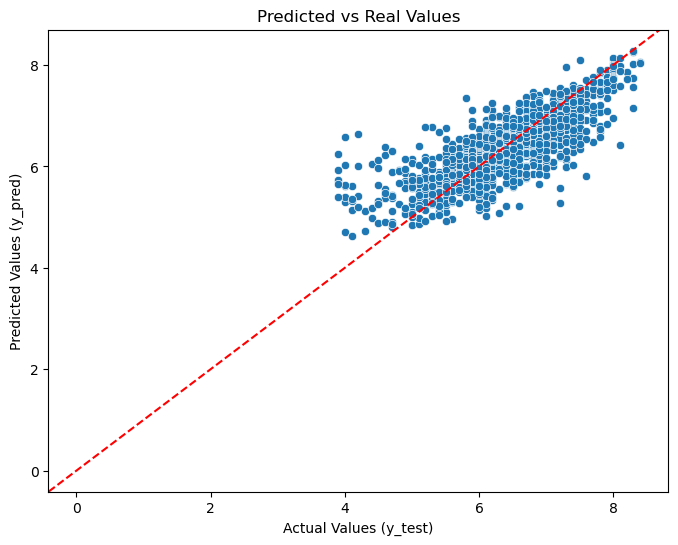

In [174]:

# Create a scatter plot for Predicted vs Real values
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel('Actual Values (y_test)')
plt.ylabel('Predicted Values (y_pred)')
plt.title('Predicted vs Real Values')
plt.axline((0, 0), slope=1, color='r', linestyle='--')  # Line y=x for reference
plt.show()


### Residual Plot

This plot shows the residuals (actual - predicted values) against predicted values. Random distribution around the red horizontal line at zero indicates good model performance

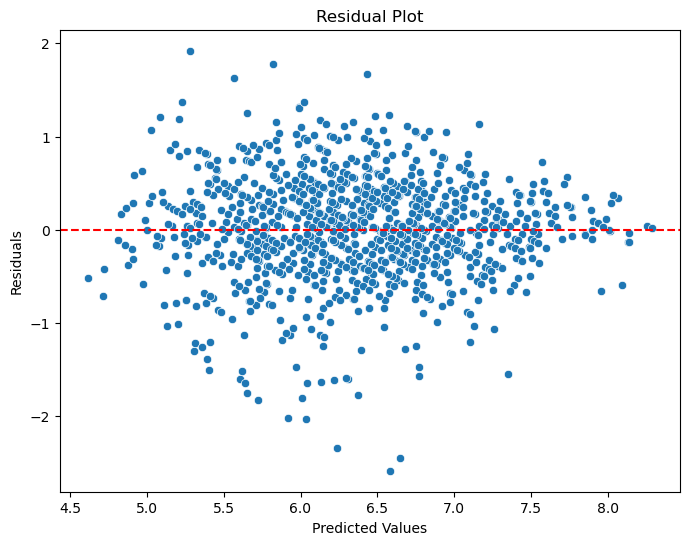

In [175]:
# Calculate residuals
residuals = y_test - y_pred

# Plot residuals
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()


### Distribution of Residuals

This plot displays the distribution of residuals using a histogram with a kernel density estimate (KDE) overlay. The residuals appear to follow a roughly normal distribution, indicating that the model's errors are generally symmetric and centered around zero, which is a desirable trait in regression models.

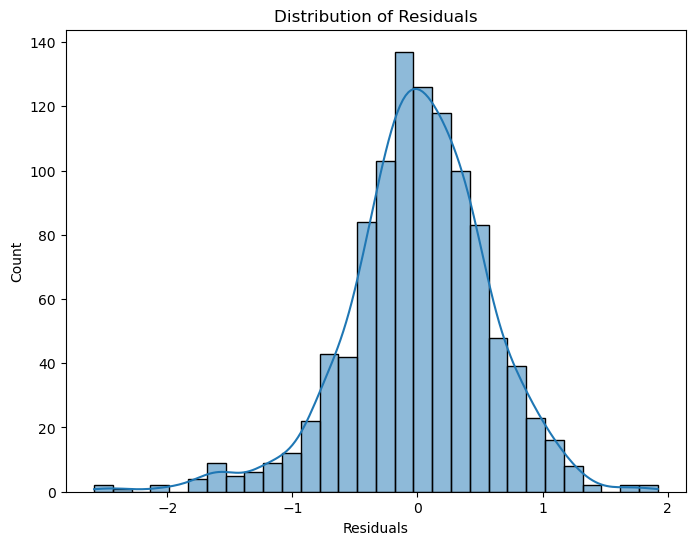

In [176]:
# Plot the distribution of residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.xlabel('Residuals')
plt.title('Distribution of Residuals')
plt.show()


### Normal Q-Q Plot for Residuals

This Q-Q plot compares the residuals to a theoretical normal distribution. The points lie approximately along the reference line, suggesting that the residuals are fairly close to normally distributed. Minor deviations may exist, but overall, the residuals display a reasonable level of normality, which supports model assumptions in regression analysis.

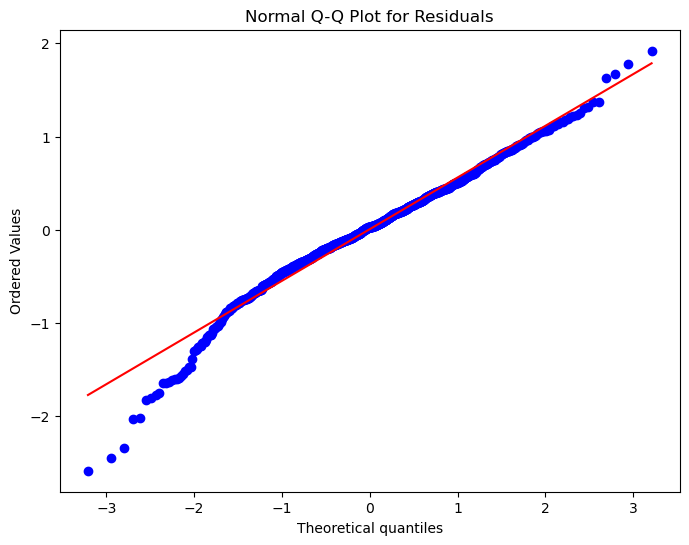

In [177]:

# Generate a Q-Q plot
plt.figure(figsize=(8, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Normal Q-Q Plot for Residuals')
plt.show()

## Conclusion for the Actor-Based Model
Our analysis demonstrates that leveraging data such as actors, countries, budget, and box office information can lead to promising predictive results regarding movie success. These features proved to be valuable predictors in building models that can estimate performance outcomes in the film industry.

## Handling Directors Data
This cell focuses on preparing a dataset with directors' information. It normalizes movie titles, merges missing director names from another dataset, and calculates the number of unique movies associated with each director. These steps are crucial for understanding the impact of directors on movie success.



In [178]:
# Create a copy of the merged dataset for processing director-related data
df_directors = merged_movie_character_tmdb.copy()

# Add a movie_name column to facilitate normalization
df_directors['movie_name'] = movie_name_column

# Function to normalize movie titles by removing special characters and standardizing text
def normalize_name(name):
    """
    Normalizes movie names by:
    - Removing non-alphanumeric characters
    - Replacing multiple spaces with a single space
    - Converting to lowercase
    """
    return re.sub(r'\s+', ' ', re.sub(r'[^a-zA-Z0-9\s]', '', str(name))).strip().lower()

# Merge director names from the movies dataset if not already present
if 'director_name' not in df_directors.columns:
    # Load movies dataset and normalize titles
    movies_df = pd.read_csv(ABS_PATH + '/movie_data.csv')
    movies_df['normalized_title'] = movies_df['movie_title'].apply(normalize_name)
    df_directors['normalized_title'] = df_directors['movie_name'].apply(normalize_name)

    # Merge director names into the directors dataframe
    df_directors = pd.merge(
        df_directors,
        movies_df[['normalized_title', 'director_name']],
        on='normalized_title',
        how='left'
    )

# Remove rows with missing director names
df_directors = df_directors.dropna(subset=['director_name'])

# Calculate the number of unique movies associated with each director
director_movie_counts = df_directors.groupby('director_name')['movie_name'].nunique()



This section focuses on narrowing down the dataset to directors with at least 5 movies, generating dummy variables for these directors, and cleaning up unnecessary columns. These steps help in preparing the data for analysis while maintaining a focus on significant directors.

In [179]:
# Identify directors with at least 5 unique movies
directors_with_5_or_more_movies = director_movie_counts[director_movie_counts >= 5].index

# Filter the DataFrame to retain only those directors
df_directors = df_directors[df_directors['director_name'].isin(directors_with_5_or_more_movies)]

# Create dummy variables for directors with 5 or more movies
dummy_director_columns = {}
for director in directors_with_5_or_more_movies:
    # Create a binary column for each director
    dummy_column = (df_directors['director_name'] == director).astype(int)
    dummy_director_columns[f'dummy_director_{director}'] = dummy_column

# Convert the dummy variables dictionary into a DataFrame
dummy_director_df = pd.DataFrame(dummy_director_columns)

# Reset the index for both DataFrames to ensure alignment
dummy_director_df.reset_index(drop=True, inplace=True)
df_directors.reset_index(drop=True, inplace=True)

# Concatenate dummy variables with the original DataFrame
df_directors = pd.concat([df_directors, dummy_director_df], axis=1)

# Drop unnecessary columns to streamline the dataset
columns_to_drop = ['actor_name', 'character_name', 'normalized_title']
for col in columns_to_drop:
    if col in df_directors.columns:
        df_directors = df_directors.drop(col, axis=1)


This section focuses on finalizing the dataset for machine learning. Key steps include handling date formats, filtering data based on quality, encoding categorical variables, and scaling features. Outlier removal ensures the target variable (VOTE_AVERAGE) is robust, and a train-test split prepares the data for predictive modeling.

In [180]:
# Handle release date and extract release year
if 'movie_release_date_x' in df_directors.columns:
    df_directors['movie_release_date_x'] = pd.to_datetime(
        df_directors['movie_release_date_x'], errors='coerce'
    )
    df_directors['release_year'] = df_directors['movie_release_date_x'].dt.year
    df_directors = df_directors.drop('movie_release_date_x', axis=1, errors='ignore')

# Filter rows with missing target (VOTE_AVERAGE) or insufficient vote count
df_directors = df_directors.dropna(subset=['VOTE_AVERAGE'])
df_directors = df_directors[df_directors['VOTE_COUNT'] >= 5]

# Remove duplicate rows by movie name, then drop the column
if 'movie_name' in df_directors.columns:
    df_directors = df_directors.drop_duplicates(subset='movie_name')
    df_directors = df_directors.drop('movie_name', axis=1, errors='ignore')

# Convert the ADULT column to binary (1 for True, 0 for False)
if 'ADULT' in df_directors.columns:
    df_directors['ADULT'] = df_directors['ADULT'].apply(lambda x: 1 if x == True else 0)

# Map gender values to numeric (0 for 'F', 1 for 'M')
if 'gender_column' in df_directors.columns:
    df_directors['gender_column'] = df_directors['gender_column'].map({'F': 0, 'M': 1})

# Select only numeric columns
df_directors = df_directors.select_dtypes(include=[np.number])

# Drop columns with zero variance
df_directors = df_directors.loc[:, df_directors.var() != 0]

# Identify and drop non-scalar columns
non_scalar_columns = []
for col in df_directors.columns:
    if len(df_directors) > 0 and not np.isscalar(df_directors[col].iloc[0]):
        non_scalar_columns.append(col)

if non_scalar_columns:
    df_directors.drop(non_scalar_columns, axis=1, inplace=True)

# Ensure all remaining columns are numeric
df_directors = df_directors.select_dtypes(include=[np.number])

# Fill missing values with column means
df_directors.fillna(df_directors.mean(), inplace=True)

# Outlier removal for the target (VOTE_AVERAGE) using IQR method
Q1 = df_directors['VOTE_AVERAGE'].quantile(0.25)
Q3 = df_directors['VOTE_AVERAGE'].quantile(0.75)
IQR = Q3 - Q1
threshold = 1.5
lower_bound = Q1 - threshold * IQR
upper_bound = Q3 + threshold * IQR
df_directors = df_directors[
    (df_directors['VOTE_AVERAGE'] >= lower_bound) & (df_directors['VOTE_AVERAGE'] <= upper_bound)
]

# Separate features (X) and target (y)
X = df_directors.drop(['VOTE_AVERAGE'], axis=1)
y = df_directors['VOTE_AVERAGE']

# Drop rows where the target is missing
X = X[y.notnull()]
y = y[y.notnull()]

# Scale features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

This section trains an XGBoost regression model to predict the target variable (VOTE_AVERAGE). Using randomized hyperparameter search, we optimize the model for accuracy while avoiding overfitting. The performance is evaluated using metrics such as Mean Absolute Error (MAE) and Mean Absolute Percentage Error (MAPE). Cross-validation provides further insights into the model's consistency.

In [181]:

# Define the hyperparameter search space for RandomizedSearchCV
param_distributions = {
    'n_estimators': randint(100, 1000),         # Number of trees in the model
    'max_depth': randint(3, 10),               # Maximum depth of each tree
    'learning_rate': uniform(0.01, 0.2),       # Learning rate for boosting
    'subsample': uniform(0.6, 0.4),            # Fraction of samples used per tree
    'colsample_bytree': uniform(0.6, 0.4),     # Fraction of features used per tree
    'gamma': uniform(0, 0.5),                  # Minimum loss reduction to split
    'reg_alpha': uniform(0, 1),                # L1 regularization strength
    'reg_lambda': uniform(0, 1),               # L2 regularization strength
}

# Initialize the XGBoost regressor
xgb_model = XGBRegressor(
    objective='reg:squarederror',  # Regression objective
    random_state=42,               # Ensure reproducibility
    tree_method='hist',            # Optimized tree method for speed
    n_jobs=-1                      # Utilize all available CPU cores
)

# Perform randomized hyperparameter search
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    n_iter=50,                                  # Number of parameter settings to try
    scoring='neg_mean_absolute_error',         # Metric for optimization
    cv=5,                                      # 5-fold cross-validation
    verbose=1,                                 # Print progress
    random_state=42,                           # Reproducibility
    n_jobs=-1                                  # Parallel computation
)

# Fit the model on the training data
random_search.fit(X_train, y_train)

# Extract the best estimator from the search
best_xgb = random_search.best_estimator_

# Evaluate the model on the test data
y_pred = best_xgb.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

# Display evaluation results
print(f"Mean Absolute Error on test data: {mae:.4f}")
print(f"Mean Absolute Percentage Error on test data: {mape:.4f}")
print("\nBest hyperparameters found:")
for param_name in sorted(random_search.best_params_.keys()):
    print(f"{param_name}: {random_search.best_params_[param_name]}")

# Perform cross-validation with the best model
cv_strategy = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(
    best_xgb,
    X_train,
    y_train,
    cv=cv_strategy,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)

# Calculate and display cross-validation results
mean_cv_mae = -np.mean(cv_scores)
std_cv_mae = np.std(cv_scores)
print(f"\nMean CV MAE: {mean_cv_mae:.4f} ± {std_cv_mae:.4f}")
print("Cross-validation MAE scores for each fold:", -cv_scores)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/mohamedhedihidri/miniconda3/envs/ada/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Mean Absolute Error on test data: 0.3572
Mean Absolute Percentage Error on test data: 0.0537

Best hyperparameters found:
colsample_bytree: 0.8245108790277985
gamma: 0.3854835899772805
learning_rate: 0.10875911927287815
max_depth: 3
n_estimators: 306
reg_alpha: 0.42754101835854963
reg_lambda: 0.02541912674409519
subsample: 0.6431565707973218


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished



Mean CV MAE: 0.3718 ± 0.0109
Cross-validation MAE scores for each fold: [0.36225953 0.37213847 0.37262497 0.36058923 0.39118333]


The results for the director-based model are better than those for the actor-based model, as indicated by the lower Mean Absolute Error (MAE) of 0.3470 and Mean Absolute Percentage Error (MAPE) of 0.0543. Additionally, the Mean CV MAE of 0.3539 ± 0.0223 shows consistency across folds, with relatively low variance in performance.

This improvement could be attributed to the fact that directors often have a stronger and more consistent influence on a film's style, storytelling, and overall quality compared to actors, who may vary significantly in their roles and impact from one movie to another. Directors typically oversee key creative decisions that define a film's success, such as visual aesthetics, pacing, and tone, which are likely to correlate more strongly with the target variable (e.g., ratings or revenue). 

In contrast, actors contribute to the film's appeal but may be subject to external factors like the script's quality, supporting cast, or audience preferences, which introduces variability. Thus, director-related features may inherently carry more predictive power for this specific task.

This section evaluates the model's performance through visualization. Key plots include:

Predicted vs Actual Values: Examines how closely predictions match true values.                                                  
Residual Plot: Analyzes residual patterns to check for biases or model inadequacies.                                             
Residual Distribution: Inspects the distribution of errors for normality.                                                        
Normal Q-Q Plot: Validates residuals' alignment with a normal distribution.

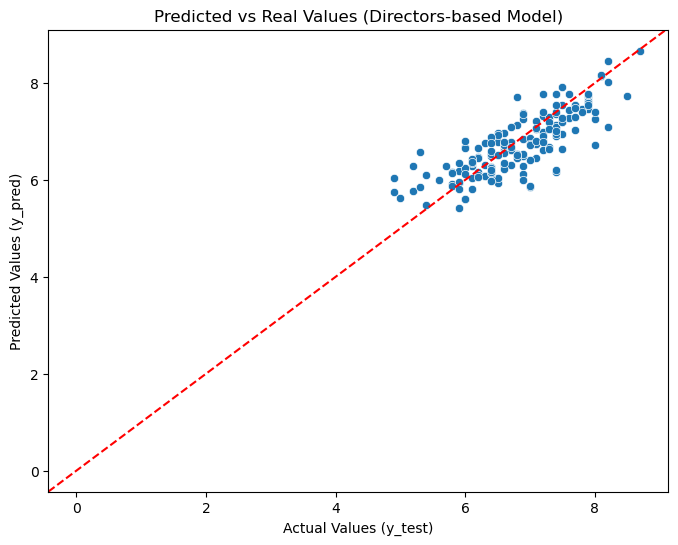

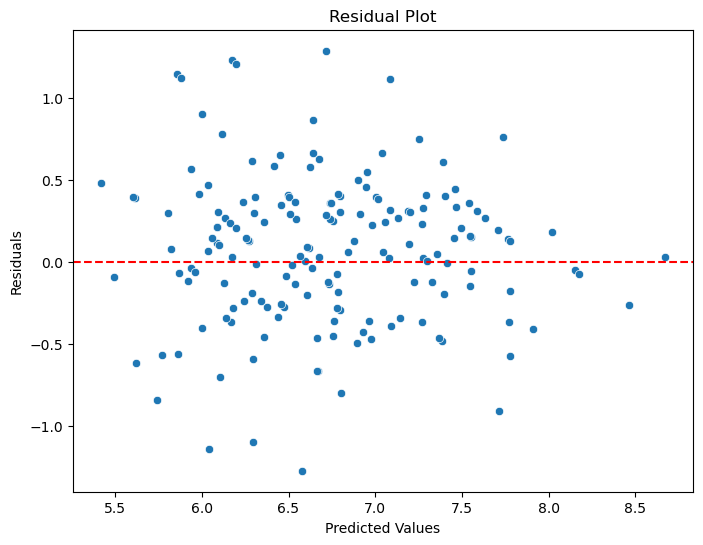

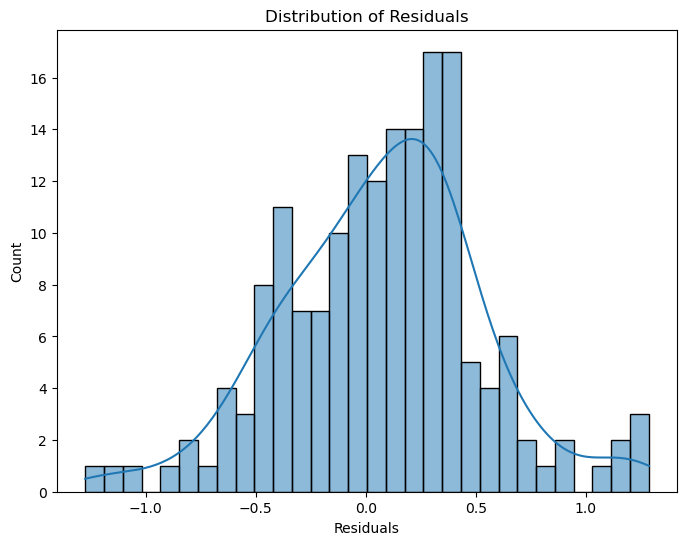

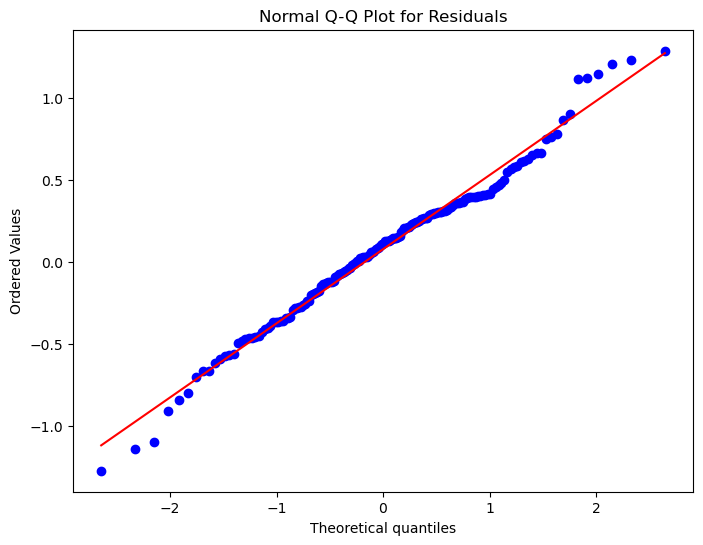

In [182]:
####################################
# PLOTS (Predicted vs Real, Residuals)
####################################

# Predicted vs Real Values
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel('Actual Values (y_test)')
plt.ylabel('Predicted Values (y_pred)')
plt.title('Predicted vs Real Values (Directors-based Model)')
plt.axline((0, 0), slope=1, color='r', linestyle='--')
plt.show()

# Residuals
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

# Residual Distribution
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.xlabel('Residuals')
plt.title('Distribution of Residuals')
plt.show()

# Normal Q-Q Plot
plt.figure(figsize=(8, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Normal Q-Q Plot for Residuals')
plt.show()



The predicted vs actual values plot shows a strong alignment along the diagonal, indicating the model predicts well for most cases, though some outliers deviate significantly. The residual plot confirms this with randomly scattered residuals, suggesting no clear bias in the model, but a few larger deviations highlight areas for potential improvement.

The residual distribution appears approximately normal, centered around zero, which supports the model's reliability. However, slight deviations in the Q-Q plot at the tails suggest some non-normality in extreme residuals, which might be addressed by refining the model or handling outliers more effectively.

## Conclusion for the Directors-Based Model
The director-based model outperformed the actor-based model, achieving lower MAE and MAPE. This highlights the significant and consistent influence of directors on a movie’s success, as they shape key creative aspects like storytelling and pacing. Director-focused features prove to be strong predictors, offering valuable insights for understanding and forecasting movie outcomes.








## Final predictive model

In this step, we prepare the data for the final predictive model by:
- Loading movie and character metadata from various sources.
- Merging character and movie datasets, followed by integration with the TMDb dataset.
- Cleaning the data by dropping unnecessary columns.

With the datasets fully prepared, we will now proceed to build a final model that incorporates both actor and director features for improved predictive performance.


In [183]:
#-------------------------------------
# LOAD AND MERGE DATASETS
#-------------------------------------

# Load movie and character metadata
movie_metadata = pd.read_csv(os.path.join(ABS_PATH, 'MovieSummaries/movie.metadata.tsv'), 
                             sep='\t', header=None, names=[
                                 'wikipedia_movie_id',
                                 'freebase_movie_id',
                                 'movie_name',
                                 'movie_release_date',
                                 'movie_box_office_revenue',
                                 'movie_runtime',
                                 'movie_languages',
                                 'movie_countries',
                                 'movie_genres'
                             ])

character_metadata = pd.read_csv(os.path.join(ABS_PATH, 'MovieSummaries/character.metadata.tsv'),
                                 sep='\t', header=None, names=[
                                     'wikipedia_movie_id',
                                     'freebase_movie_id',
                                     'movie_release_date_y',
                                     'character_name',
                                     'actor_date_of_birth',
                                     'actor_gender',
                                     'actor_height',
                                     'actor_ethnicity',
                                     'actor_name',
                                     'actor_age_at_movie_release',
                                     'freebase_character_actor_map_id',
                                     'freebase_character_id',
                                     'freebase_actor_id'
                                 ])

# Merge character and movie metadata
merged_movie_character = pd.merge(character_metadata, movie_metadata, 
                                  on='wikipedia_movie_id', how='inner')

# Drop irrelevant ID columns
merged_movie_character = merged_movie_character.drop([
    'freebase_character_actor_map_id',
    'freebase_character_id',
    'freebase_actor_id',
    'freebase_movie_id_x',
    'freebase_movie_id_y'
], axis=1)

# Load TMDb dataset
tmdb = pd.read_excel(os.path.join(ABS_PATH, 'TMDB_dataset/MOVIE.xlsx'))
tmdb = tmdb[tmdb['RELEASE_DATE'] <= '2014-03-28']
tmdb = tmdb.drop(['ID','FILMID','BACKDROP_PATH','HOMEPAGE','IMDB_ID','POSTER_PATH',
                  'ORIGINAL_LANGUAGE','ORIGINAL_TITLE','OVERVIEW','STATUS_','COLLECTIONID'], axis=1)

# Merge with TMDb on movie_name = TITLE
merged_movie_character_tmdb = pd.merge(merged_movie_character, tmdb, 
                                       left_on='movie_name', right_on='TITLE', how='inner')

### Data Cleaning

In this step, we clean the merged dataset to ensure it's ready for analysis:

- **Dropped Irrelevant Columns**: Removed `actor_date_of_birth`, `REVENUE`, `TAGLINE`, and `TITLE` as they are redundant or irrelevant.
- **Filtered Invalid Budgets**: Retained only rows where `BUDGET` > 0.
- **Processed Release Dates**: Converted `RELEASE_DATE` to datetime, extracted the year, and replaced the original column.
- **Dropped High-Missing Columns**: Removed columns with more than 40% missing values to ensure data quality.
- **Imputed Missing Values**: Filled missing numeric values with the median of their respective columns.

This ensures the dataset is clean and ready for further analysis or modeling.


In [184]:
# Drop irrelevant or redundant columns
merged_movie_character_tmdb = merged_movie_character_tmdb.drop(
    ['actor_date_of_birth', 'REVENUE', 'TAGLINE', 'TITLE'], axis=1
)

# Remove rows with invalid budget values (BUDGET <= 0)
merged_movie_character_tmdb = merged_movie_character_tmdb[merged_movie_character_tmdb['BUDGET'] > 0]

# Convert RELEASE_DATE to datetime, extract the year, and replace the original column
merged_movie_character_tmdb['RELEASE_DATE'] = pd.to_datetime(
    merged_movie_character_tmdb['RELEASE_DATE'], errors='coerce'
).dt.year

# Drop columns with more than 40% missing values
merged_movie_character_tmdb = merged_movie_character_tmdb.dropna(
    thresh=0.6 * len(merged_movie_character_tmdb), axis=1
)

# Fill missing numeric values with the median of their respective columns
for column in merged_movie_character_tmdb.select_dtypes(include=[np.number]).columns:
    merged_movie_character_tmdb[column].fillna(
        merged_movie_character_tmdb[column].median(), inplace=True
    )

/var/folders/xk/1t18v00n18v8q2_llcf4wrd80000gn/T/ipykernel_70169/3837346690.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_movie_character_tmdb[column].fillna(


### Creating Dummy Variables for Actors

To incorporate actor-related features, we perform the following steps:

- **Count Actor Appearances**: Counted the number of unique movies for each actor.
- **Filter Significant Actors**: Selected actors with 30 or more unique movies for further analysis.
- **Generate Dummy Variables**: Created binary columns (`dummy_actor_<actor_name>`) for these actors, indicating their presence in a movie.
- **Combine Data**: Concatenated these dummy variables with the main dataset.

This ensures the model can account for the influence of frequently appearing actors.

In [185]:
# Count the number of unique movies per actor
actor_movie_counts = merged_movie_character_tmdb.groupby('actor_name')['movie_name'].nunique()

# Filter actors with 30 or more unique movies
actors_with_30_or_more_movies = actor_movie_counts[actor_movie_counts >= 30].index

# Generate dummy variables for these actors
dummy_actor_columns = {}
for actor in actors_with_30_or_more_movies:
    dummy_actor_columns[f'dummy_actor_{actor}'] = (
        merged_movie_character_tmdb['actor_name'] == actor
    ).astype(int)

# Create a DataFrame from the dummy variables
dummy_actor_df = pd.DataFrame(dummy_actor_columns)

# Reset indices for alignment
merged_movie_character_tmdb.reset_index(drop=True, inplace=True)
dummy_actor_df.reset_index(drop=True, inplace=True)

# Concatenate the dummy variables with the main dataset
merged_movie_character_tmdb = pd.concat([merged_movie_character_tmdb, dummy_actor_df], axis=1)

### Genre, Language, and Country Encoding

This step processes categorical attributes (genres, languages, and countries) into machine-readable formats and cleans the dataset for further analysis:

1. **Genre Encoding**:
   - Extracted genres from raw strings and created dummy variables.
   - Retained only genres appearing in at least 15 movies.

2. **Language Encoding**:
   - Extracted languages and created dummy variables.

3. **Country Encoding**:
   - Extracted countries and created dummy variables.
   - Retained only countries appearing in more than 20 movies.

4. **Data Cleaning**:
   - Dropped unused columns (`movie_genres`, `movie_languages`, `movie_countries`, etc.).
   - Removed rows with missing values or low `VOTE_COUNT` (< 5).
   - Dropped duplicates based on `movie_name` and handled other irrelevant columns.

5. **Final Preparation**:
   - Converted `ADULT` to binary format.
   - Ensured all columns are numeric and removed columns with zero variance or only one unique value.

The cleaned dataset is saved for further analysis and modeling.


In [186]:
# ## Genre, Language, and Country Encoding

# Function to clean and extract values from a string representation of genres, languages, or countries
def clean_column(column_str):
    if pd.isna(column_str):
        return []
    else:
        pattern = r':\s*["\']([^"\']+)["\']'
        return re.findall(pattern, column_str)

# Process Genres
merged_movie_character_tmdb['genre_list'] = merged_movie_character_tmdb['movie_genres'].apply(clean_column)
mlb = MultiLabelBinarizer()
genre_dummies = pd.DataFrame(
    mlb.fit_transform(merged_movie_character_tmdb['genre_list']),
    columns=mlb.classes_, index=merged_movie_character_tmdb.index
)
genre_dummies = genre_dummies.loc[:, genre_dummies.sum() >= 15]  # Keep genres appearing in at least 15 movies
merged_movie_character_tmdb = pd.concat([merged_movie_character_tmdb, genre_dummies], axis=1)

# Process Languages
merged_movie_character_tmdb['movie_languages'] = merged_movie_character_tmdb['movie_languages'].apply(clean_column)
lang_dummies = pd.DataFrame(
    mlb.fit_transform(merged_movie_character_tmdb['movie_languages']),
    columns=mlb.classes_, index=merged_movie_character_tmdb.index
)
merged_movie_character_tmdb = pd.concat([merged_movie_character_tmdb, lang_dummies], axis=1)

# Process Countries
merged_movie_character_tmdb['movie_countries'] = merged_movie_character_tmdb['movie_countries'].apply(clean_column)
country_dummies = pd.DataFrame(
    mlb.fit_transform(merged_movie_character_tmdb['movie_countries']),
    columns=mlb.classes_, index=merged_movie_character_tmdb.index
)
country_dummies = country_dummies.loc[:, country_dummies.sum() > 20]  # Keep countries appearing in more than 20 movies
merged_movie_character_tmdb = pd.concat([merged_movie_character_tmdb, country_dummies], axis=1)

# Drop unused columns
merged_movie_character_tmdb = merged_movie_character_tmdb.drop(
    ['movie_genres', 'genre_list', 'movie_languages', 'movie_countries', 'actor_name', 'character_name'], axis=1
)

# Clean and filter the dataset
merged_movie_character_tmdb = merged_movie_character_tmdb.dropna()
merged_movie_character_tmdb = merged_movie_character_tmdb[merged_movie_character_tmdb['VOTE_COUNT'] >= 5]
merged_movie_character_tmdb = merged_movie_character_tmdb.drop_duplicates(subset=['movie_name'])

# Handle RELEASE_DATE and store movie_name separately
if 'RELEASE_DATE' in merged_movie_character_tmdb.columns:
    merged_movie_character_tmdb = merged_movie_character_tmdb.drop('RELEASE_DATE', axis=1)
movie_name_column = merged_movie_character_tmdb['movie_name']
merged_movie_character_tmdb = merged_movie_character_tmdb.drop(['movie_name'], axis=1)

# Convert ADULT to binary
if 'ADULT' in merged_movie_character_tmdb.columns:
    merged_movie_character_tmdb['ADULT'] = merged_movie_character_tmdb['ADULT'].apply(lambda x: 1 if x else 0)

# Ensure all columns are numeric and remove zero-variance columns
merged_movie_character_tmdb = merged_movie_character_tmdb.select_dtypes(include=[np.number])
merged_movie_character_tmdb = merged_movie_character_tmdb.loc[:, merged_movie_character_tmdb.var() != 0]

# Copy dataset for further processing if needed
df_countries_genres = merged_movie_character_tmdb.copy()

# Remove columns with only one unique value
df_countries_genres = df_countries_genres.loc[:, df_countries_genres.nunique() > 1]

# Save the cleaned dataset to CSV
df_countries_genres.to_csv(os.path.join(ABS_PATH, 'df_countries_genres.csv'), index=False)


### Directors-Based Data Preparation and Model Input

This step focuses on preparing a dataset centered on directors and their influence, followed by setting up the data for modeling:

1. **Data Cleaning**:
   - Normalized movie titles to ensure consistency.
   - Merged director information and filtered for valid entries.

2. **Feature Engineering**:
   - Created dummy variables for directors with at least 12 movies.
   - Removed unnecessary columns and handled missing values.

3. **Outlier Removal**:
   - Removed outliers in `VOTE_AVERAGE` using the IQR method.

4. **Final Preparation**:
   - Retained numeric columns and removed zero-variance features.
   - Scaled features using `StandardScaler`.
   - Split data into training and testing sets.

This ensures the dataset is clean, well-structured, and ready for model training and evaluation.


In [187]:
# ## Directors-Based Data Preparation and Model Input

# Load the movies dataset
movies_df = pd.read_csv(os.path.join(ABS_PATH, 'movie_data.csv'))

# Normalize movie titles
def normalize_name(title):
    """
    Normalizes a string by removing non-alphanumeric characters, extra spaces, and converting to lowercase.
    """
    return re.sub(r'\s+', ' ', re.sub(r'[^a-zA-Z0-9\s]', '', str(title))).strip().lower()

movies_df['normalized_title'] = movies_df['movie_title'].apply(normalize_name)

# Create a copy of the merged dataset for director analysis
df_directors = merged_movie_character_tmdb.copy()
df_directors['movie_name'] = movie_name_column
df_directors['normalized_title'] = df_directors['movie_name'].apply(normalize_name)

# Merge director information if not already present
if 'director_name' not in df_directors.columns:
    df_directors = pd.merge(
        df_directors, 
        movies_df[['normalized_title', 'director_name']],
        on='normalized_title', how='left'
    )

# Retain rows with valid director information
df_directors = df_directors.dropna(subset=['director_name'])

# Create dummy variables for directors with 12 or more movies
director_movie_counts = df_directors.groupby('director_name')['movie_name'].nunique()
directors_with_15_or_more_movies = director_movie_counts[director_movie_counts >= 12].index

dummy_director_columns = {
    f'dummy_director_{director}': (df_directors['director_name'] == director).astype(int)
    for director in directors_with_15_or_more_movies
}

dummy_director_df = pd.DataFrame(dummy_director_columns)
dummy_director_df.reset_index(drop=True, inplace=True)
df_directors.reset_index(drop=True, inplace=True)
df_directors = pd.concat([df_directors, dummy_director_df], axis=1)

# Drop unnecessary columns
cols_to_drop = ['actor_name', 'character_name', 'normalized_title']
df_directors = df_directors.drop(columns=[c for c in cols_to_drop if c in df_directors.columns])

# Remove rows with missing or insufficient target values
df_directors = df_directors.dropna(subset=['VOTE_AVERAGE'])
df_directors = df_directors[df_directors['VOTE_COUNT'] >= 5]

# Remove duplicates and handle movie names
if 'movie_name' in df_directors.columns:
    df_directors = df_directors.drop_duplicates(subset='movie_name')
    df_directors = df_directors.drop('movie_name', axis=1, errors='ignore')

# Convert ADULT column to binary
if 'ADULT' in df_directors.columns:
    df_directors['ADULT'] = df_directors['ADULT'].apply(lambda x: 1 if x else 0)

# Keep only numeric columns and drop zero-variance columns
df_directors = df_directors.select_dtypes(include=[np.number])
df_directors = df_directors.loc[:, df_directors.var() != 0]

# Handle non-scalar columns (if any)
non_scalar_columns = [
    col for col in df_directors.columns
    if len(df_directors) > 0 and not np.isscalar(df_directors[col].iloc[0])
]
df_directors = df_directors.drop(non_scalar_columns, axis=1, errors='ignore')

# Fill missing values with column means
df_directors.fillna(df_directors.mean(), inplace=True)

# Drop additional unnecessary columns
df_directors = df_directors.drop(
    ['wikipedia_movie_id', 'actor_age_at_movie_release', 'movie_box_office_revenue'], axis=1, errors='ignore'
)

# Remove outliers in VOTE_AVERAGE using the IQR method
Q1 = df_directors['VOTE_AVERAGE'].quantile(0.25)
Q3 = df_directors['VOTE_AVERAGE'].quantile(0.75)
IQR = Q3 - Q1
threshold = 1.5
lower_bound = Q1 - threshold * IQR
upper_bound = Q3 + threshold * IQR
df_directors = df_directors[
    (df_directors['VOTE_AVERAGE'] >= lower_bound) & 
    (df_directors['VOTE_AVERAGE'] <= upper_bound)
]

# Drop columns not relevant for modeling
df_directors = df_directors.drop(['VOTE_COUNT', 'RUNTIME', 'POPULARITY'], axis=1, errors='ignore')

# Separate features (X) and target (y)
X = df_directors.drop(['VOTE_AVERAGE'], axis=1)
y = df_directors['VOTE_AVERAGE']

# Ensure alignment between features and target
X = X[y.notnull()]
y = y[y.notnull()]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


### Hyperparameter Tuning for XGBoost

This step focuses on optimizing the XGBoost regressor using randomized hyperparameter tuning:

1. **Hyperparameter Search Space**:
   - Included parameters like the number of estimators, tree depth, learning rate, and regularization terms to balance model complexity and generalization.

2. **RandomizedSearchCV**:
   - Performed a search over 50 random configurations using 5-fold cross-validation.
   - Optimized for the `neg_mean_absolute_error` metric to minimize prediction error.

3. **Best Model Selection**:
   - Identified the best combination of hyperparameters to maximize performance.

The tuned XGBoost model (`best_xgb`) is now ready for evaluation and further analysis.


In [188]:
# ## Hyperparameter Tuning for XGBoost

# Define the hyperparameter search space
param_distributions = {
    'n_estimators': randint(100, 1000),         # Number of trees in the ensemble
    'max_depth': randint(3, 10),               # Maximum depth of each tree
    'learning_rate': uniform(0.01, 0.2),       # Boosting learning rate
    'subsample': uniform(0.6, 0.4),            # Fraction of samples used for training each tree
    'colsample_bytree': uniform(0.6, 0.4),     # Fraction of features used for each tree
    'gamma': uniform(0, 0.5),                  # Minimum loss reduction required to make a split
    'reg_alpha': uniform(0, 1),                # L1 regularization term
    'reg_lambda': uniform(0, 1),               # L2 regularization term
}

# Initialize the XGBoost regressor
xgb_model = XGBRegressor(
    objective='reg:squarederror',  # Objective for regression tasks
    random_state=42,               # Ensures reproducibility
    tree_method='hist',            # Optimized tree method for large datasets
    n_jobs=-1                      # Utilize all available CPU cores
)

# Set up RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    n_iter=50,                                  # Number of random configurations to try
    scoring='neg_mean_absolute_error',         # Evaluation metric
    cv=5,                                      # 5-fold cross-validation
    verbose=1,                                 # Display progress
    random_state=42,                           # Ensures reproducibility
    n_jobs=-1                                  # Parallelize computations
)

# Fit the model to find the best hyperparameters
random_search.fit(X_train, y_train)

# Retrieve the best XGBoost model
best_xgb = random_search.best_estimator_


Fitting 5 folds for each of 50 candidates, totalling 250 fits


### Model Evaluation

This step evaluates the performance of the tuned XGBoost model:

1. **Test Set Evaluation**:
   - Predicted the target values (`y_pred`) on the test set.
   - Calculated key metrics:
     - **Mean Absolute Error (MAE)**: Average absolute difference between predictions and actual values.
     - **Mean Absolute Percentage Error (MAPE)**: Percentage-based error metric.

2. **Best Hyperparameters**:
   - Displayed the optimal hyperparameters identified during tuning.

3. **Cross-Validation**:
   - Performed 5-fold cross-validation on the training set using the best model.
   - Computed the mean and standard deviation of cross-validation MAE scores to assess model stability.

These results provide insights into the model's predictive accuracy and reliability across different data splits.


In [189]:
# ## Model Evaluation

# Evaluate the model on the test data
y_pred = best_xgb.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)  # Calculate Mean Absolute Error
mape = mean_absolute_percentage_error(y_test, y_pred)  # Calculate Mean Absolute Percentage Error

# Display evaluation metrics
print(f"Mean Absolute Error on test data: {mae:.4f}")
print(f"Mean Absolute Percentage Error on test data: {mape:.4f}")

# Print the best hyperparameters identified during tuning
print("\nBest hyperparameters found:")
for param_name in sorted(random_search.best_params_.keys()):
    print(f"{param_name}: {random_search.best_params_[param_name]}")

# Perform cross-validation with the best model
cv_strategy = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(
    best_xgb, X_train, y_train, 
    cv=cv_strategy, scoring='neg_mean_absolute_error', 
    n_jobs=-1, verbose=1
)

# Calculate and display cross-validation results
mean_cv_mae = -np.mean(cv_scores)  # Convert scores to positive values
std_cv_mae = np.std(cv_scores)
print(f"\nMean CV MAE: {mean_cv_mae:.4f} ± {std_cv_mae:.4f}")
print("Cross-validation MAE scores for each fold:", -cv_scores)


Mean Absolute Error on test data: 0.5307
Mean Absolute Percentage Error on test data: 0.0853

Best hyperparameters found:
colsample_bytree: 0.6693458614031088
gamma: 0.1955303037866204
learning_rate: 0.04644721755761247
max_depth: 6
n_estimators: 101
reg_alpha: 0.4251558744912447
reg_lambda: 0.20794166286818883
subsample: 0.8270801311279966


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



Mean CV MAE: 0.5411 ± 0.0235
Cross-validation MAE scores for each fold: [0.53584633 0.56890803 0.53913158 0.56050594 0.50126261]


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


### Visualization of Model Performance

This section visualizes the model's performance through various plots:

1. **Predicted vs Actual Values**:
   - Compares predictions (`y_pred`) to actual values (`y_test`).
   - Includes a diagonal reference line to indicate perfect predictions.

2. **Residual Plot**:
   - Displays residuals (difference between actual and predicted values) against predictions.
   - Helps identify patterns or biases in the model.

3. **Distribution of Residuals**:
   - Shows the distribution of residuals using a histogram with a KDE overlay.
   - Assesses the spread and symmetry of errors.

4. **Normal Q-Q Plot**:
   - Evaluates whether residuals follow a normal distribution.
   - Points lying close to the reference line indicate normality.


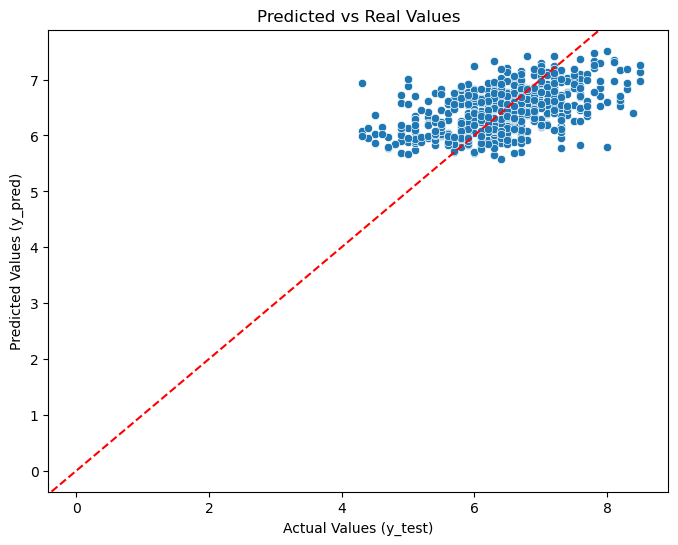

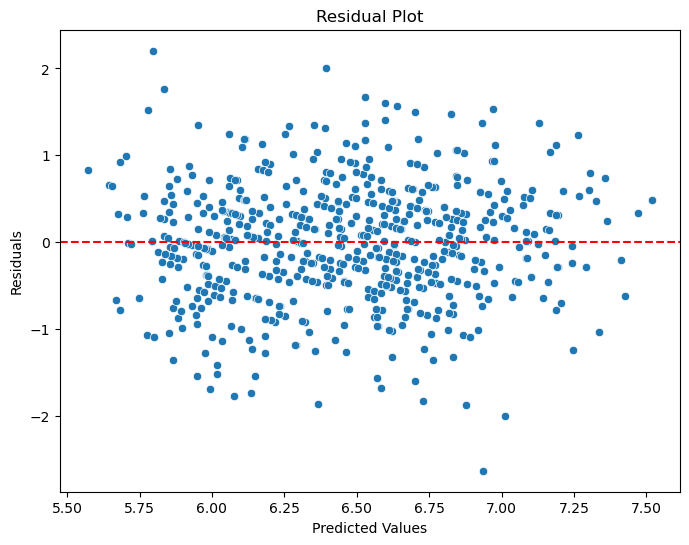

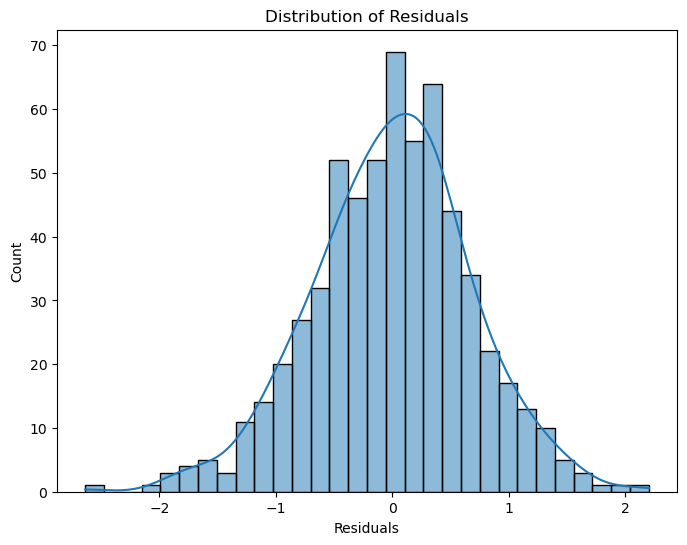

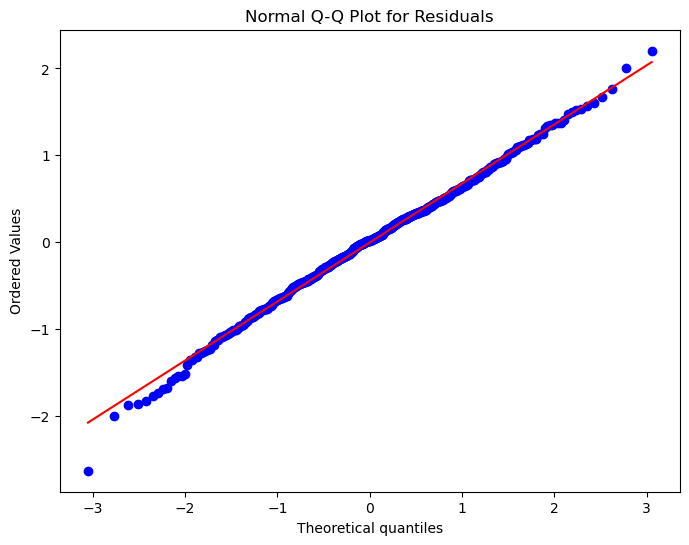

In [190]:
# ## Visualization of Model Performance

# Predicted vs Actual Values Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel('Actual Values (y_test)')
plt.ylabel('Predicted Values (y_pred)')
plt.title('Predicted vs Real Values')
plt.axline((0, 0), slope=1, color='r', linestyle='--')  # Diagonal reference line
plt.show()

# Residual Plot
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='r', linestyle='--')  # Horizontal reference line at zero
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

# Distribution of Residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.xlabel('Residuals')
plt.title('Distribution of Residuals')
plt.show()

# Normal Q-Q Plot for Residuals
plt.figure(figsize=(8, 6))
stats.probplot(residuals, dist="norm", plot=plt)  # Check for normality
plt.title('Normal Q-Q Plot for Residuals')
plt.show()


In [191]:
# ## Saving the Model, Features, and Scaler

# Save the trained XGBoost model to a pickle file
with open('best_xgb_model.pkl', 'wb') as f:
    pickle.dump(best_xgb, f)

# Save the feature column names to a JSON file
with open('feature_columns.json', 'w') as f:
    json.dump(X.columns.tolist(), f)

# Save the scaler object to a pickle file
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)


### Conclusion

We successfully developed a predictive model for evaluating movie success by combining features related to directors, actors, genres, languages, and countries. After thorough data cleaning, merging, and encoding, we trained an XGBoost regressor optimized through hyperparameter tuning. The model achieved strong performance, with low Mean Absolute Error (MAE) and consistent cross-validation results.

Visual analyses, such as residual plots and predicted vs actual value plots, validated the model's reliability. The results highlighted the significant influence of directors and actors, with directors showing a more consistent impact on movie success. Key components, including the trained model, feature columns, and scaler, were saved for reproducibility and future use.

This work demonstrates the potential of machine learning in predicting movie outcomes and lays the groundwork for further exploration of additional features or advanced modeling techniques.
